## Capstone Project 1

This Jupyter Notebook documents the development of a Machine Learning project focused on predicting the price of Ford cars. The project aims to create a reliable and scalable solution for car price prediction using historical data, exploring patterns in features like mileage, year, and specifications.

### Project Overview

The objective is to predict the price of Ford cars based on their attributes. Accurate price predictions are crucial for car dealerships, online platforms, and individual sellers to make data-driven pricing decisions. This project provides a structured approach, from data exploration to model deployment, ensuring the solution is practical and usable.

### Data preparation

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1. Data Loading

In [29]:
data = pd.read_csv("ford_car_price_prediction.csv")
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Basic overview

In [34]:
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())

     model  year  price transmission  mileage fueltype  tax   mpg  enginesize
0   Fiesta  2017  12000    Automatic    15944   Petrol  150  57.7         1.0
1    Focus  2018  14000       Manual     9083   Petrol  150  57.7         1.0
2    Focus  2017  13000       Manual    12456   Petrol  150  57.7         1.0
3   Fiesta  2019  17500       Manual    10460   Petrol  145  40.3         1.5
4   Fiesta  2019  16500    Automatic     1482   Petrol  145  48.7         1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fueltype      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   floa

# Target definition

In [35]:
target_label = 'price'

# Identify columns

In [36]:
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if target_label in numerical_cols:
    numerical_cols.remove(target_label)

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# 2. Exploratory Data Analysis (EDA)

# (A) Histogram of Price

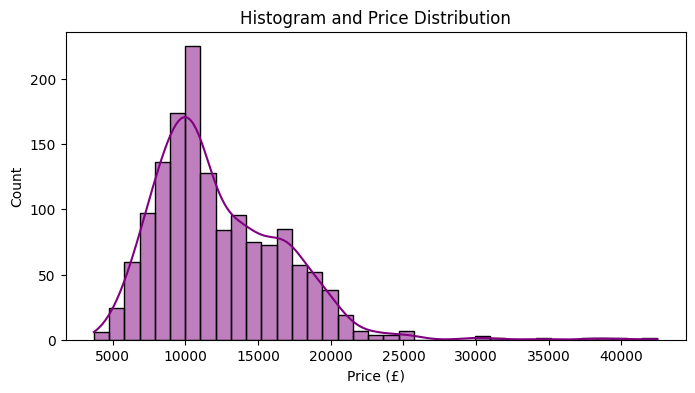

In [37]:
plt.figure(figsize=(8,4))
sns.histplot(data[target_label], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

# (B) Histograms/KDE of Numerical Columns

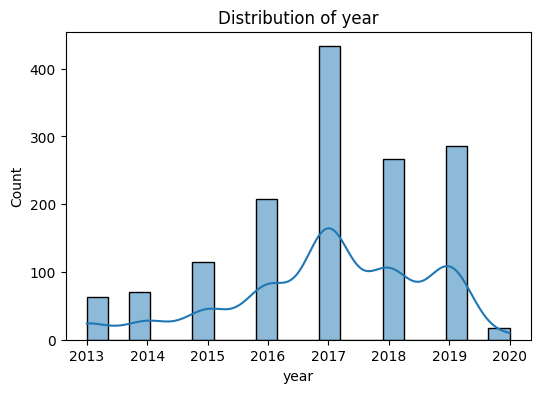

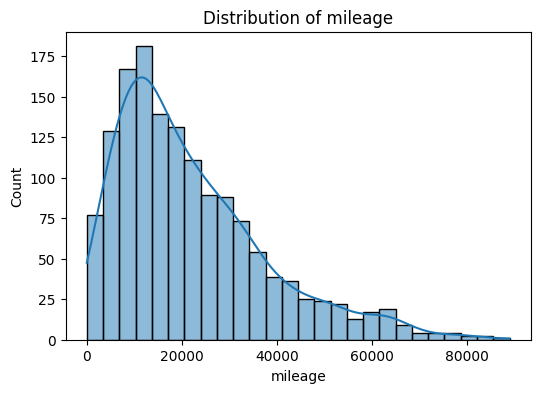

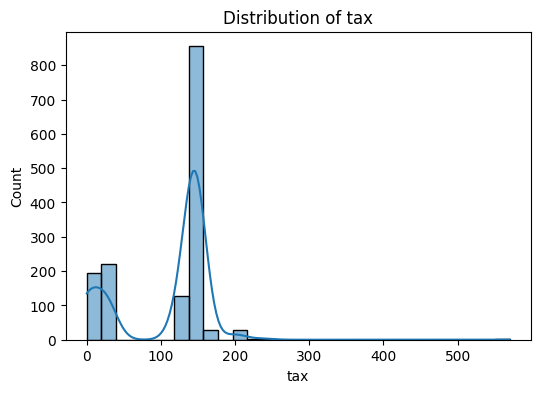

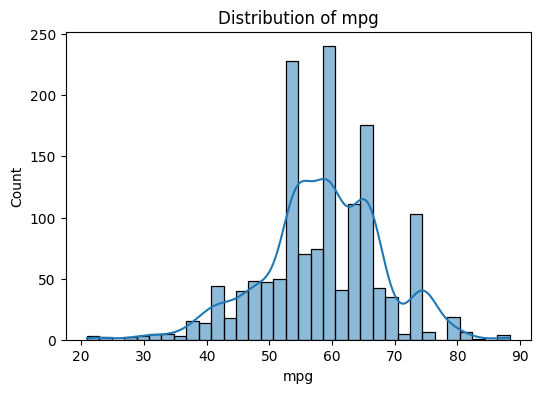

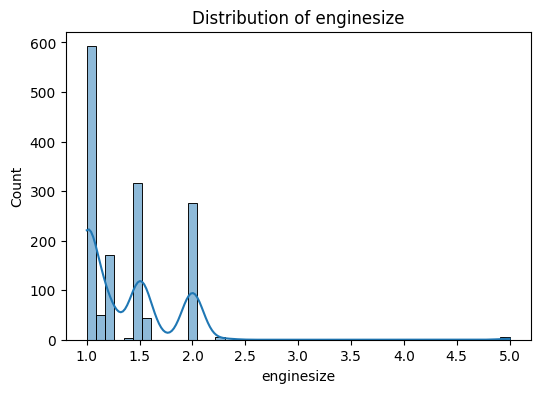

In [38]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# (C) Countplot of a Categorical Feature (Example: Brand)

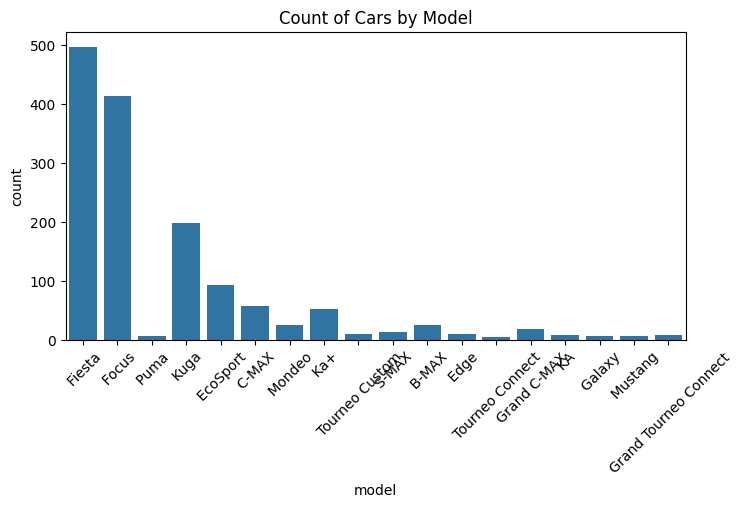

In [43]:
plt.figure(figsize=(8,4))
sns.countplot(x='model', data=data)
plt.title("Count of Cars by Model")
plt.xticks(rotation=45)
plt.show()

# (D) Violinplot: Brand vs. Price

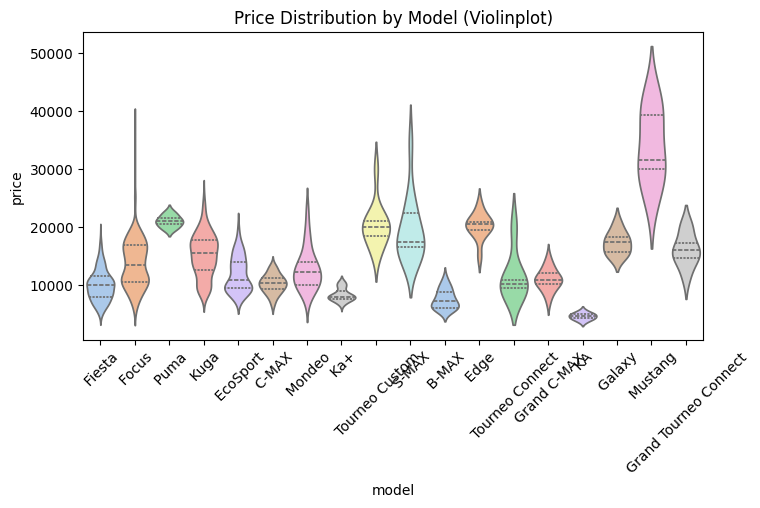

In [45]:
if 'model' in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.violinplot(x='model', y=target_label, data=data, palette='pastel', inner='quartile')
    plt.title("Price Distribution by Model (Violinplot)")
    plt.xticks(rotation=45)
    plt.show()

# (E) Stripplot with Hue

In [46]:
if 'brand' in categorical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.stripplot(x='brand', y='price', hue='transmission', data=data, jitter=True, alpha=0.6)
    plt.title("Price Distribution by Brand and Transmission")
    plt.xticks(rotation=45)
    plt.show()

# (F) Boxplot of mpg vs Brand (if both exist)

In [ ]:
if 'mpg' in numerical_cols and 'brand' in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='brand', y='mpg', data=data, palette='Set3')
    plt.title("MPG Distribution by Brand (Boxplot)")
    plt.xticks(rotation=45)
    plt.show()

# (G) Scatterplot mpg vs price, hue=transmission

In [ ]:
if 'mpg' in numerical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='mpg', y='price', hue='transmission', data=data, alpha=0.7)
    plt.title("MPG vs Price Colored by Transmission")
    plt.show()

# (H) Jointplot of Mileage vs. Price

In [ ]:
if 'mileage' in numerical_cols:
    sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=6)
    plt.suptitle("Mileage vs Price (Jointplot)", y=1.02)
    plt.show()

# (I) Regplot of Engine Size vs Price

In [ ]:
if 'engine_size' in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x='engine_size', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title("Engine Size vs Price with Regression Line")
    plt.show()

# (J) Correlation Heatmap (Numerical + Price)

In [ ]:
corr = data[numerical_cols + [target_label]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Numerical)")
plt.show()

# (K) Pairplot

In [ ]:
sns.pairplot(data, vars=numerical_cols + [target_label], corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

# 3. Data Preparation / Train-Test Split

In [ ]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train[target_label].values
y_test_final = df_test[target_label].values

X_full_train = df_full_train.drop(columns=[target_label])
X_test_final = df_test.drop(columns=[target_label])

# 4. Preprocessing Pipeline

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# 5. Multiple Models

In [ ]:
pipelines = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', LinearRegression())]),
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Ridge())]),
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Lasso())]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBRegressor(objective='reg:squarederror',
                                                      random_state=42))])
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {
        'model__alpha': np.logspace(-4, 4, 10)
    },
    'Lasso': {
        'model__alpha': np.logspace(-4, 4, 10)
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

best_params = {}
results_list = []

for name, pipeline in pipelines.items():
    print(name)
    if param_grids[name]:
        grid = GridSearchCV(estimator=pipeline,
                            param_grid=param_grids[name],
                            scoring='neg_mean_squared_error',
                            cv=5)
        grid.fit(X_full_train, y_full_train)
        best_params[name] = grid.best_params_
        best_model = grid.best_estimator_
    else:
        pipeline.fit(X_full_train, y_full_train)
        best_model = pipeline
        best_params[name] = 'No parameter tuning'
    preds = best_model.predict(X_test_final)
    rmse = mean_squared_error(y_test_final, preds, squared=False)
    r2 = r2_score(y_test_final, preds)
    results_list.append((name, rmse, r2))

for item in results_list:
    print(item[0], "RMSE:", item[1], "R2:", item[2])

# 6. Final XGBoost Model with Chosen Hyperparams

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50,
          "random_state": 42, "n_jobs": -1, "objective": "reg:squarederror"}
final_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('model', XGBRegressor(**params))]
)
final_pipeline.fit(X_full_train, y_full_train)
final_preds = final_pipeline.predict(X_test_final)
rmse_final = mean_squared_error(y_test_final, final_preds, squared=False)
r2_final = r2_score(y_test_final, final_preds)
print("Final XGBoost Model RMSE:", rmse_final, "R2:", r2_final)


# 7. Save Pipeline

In [ ]:
joblib.dump(final_pipeline, "pipeline.joblib")